In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data exploration

In [2]:
df_train = pd.DataFrame([])
df_test = pd.DataFrame([])

counts = {'pos': 0,
          'neg': 0}
test_name = 'FrameFilter-test_set'
for folder in os.listdir('data'):
    sub = os.path.join('data', folder)
    if os.path.isdir(sub):
        

        if folder !=test_name:
            for s in os.listdir(sub):

                sub_parts = os.path.join(sub, s)
                l = len(os.listdir(sub_parts))
                counts[s]+=l

                tmp  = pd.DataFrame({'root': [sub_parts for i in range(l)],
                                     'img_name': os.listdir(sub_parts),
                                     'frame': [s for i in range(l)]})
                df_train = df_train.append(tmp, ignore_index=True)
            
test_paths = os.listdir(os.path.join('data', test_name))
df_test = df_test.append(pd.DataFrame({"img_name": test_paths,
                                      'root': [os.path.join('data', test_name) for i in range(len(test_paths))]
                                      }))

print("Training: {}".format(counts))
print("Test: {}".format(len(test_paths)))

Training: {'pos': 1643, 'neg': 1335}
Test: 600


In [3]:
df_train.shape, df_test.shape 

((2978, 3), (600, 2))

-------

# Training data analysis

## splitting to see more insights on particular frame data info

In [7]:
df_train[['extraction_index', 
        'match_hash',
        'minute',
        'frame_shift',
        'frame_idx']] = df_train['img_name'].str.split('-',expand=True)
df_train[['frame_idx', 'format']] = df_train['img_name'].str.split('.', expand=True)
df_train[['extraction_index', 'minute','frame_shift']] = df_train[['extraction_index', 'minute','frame_shift']].astype(np.int)

In [8]:
df_train.head()

,root,img_name,frame,extraction_index,match_hash,minute,frame_shift,frame_idx,format
0,data/FrameFilter-set3_fhd/neg,000971-239cfe735df8fbe4597e4a43-2-600-6600.jpg,neg,971,239cfe735df8fbe4597e4a43,2,600,000971-239cfe735df8fbe4597e4a43-2-600-6600,jpg
1,data/FrameFilter-set3_fhd/neg,000526-b84576ba0a22bfb909fbed0c-3-600-5100.jpg,neg,526,b84576ba0a22bfb909fbed0c,3,600,000526-b84576ba0a22bfb909fbed0c-3-600-5100,jpg
2,data/FrameFilter-set3_fhd/neg,000380-f2c70f8a579c472e716785c3-47-600-141600.jpg,neg,380,f2c70f8a579c472e716785c3,47,600,000380-f2c70f8a579c472e716785c3-47-600-141600,jpg
3,data/FrameFilter-set3_fhd/neg,000568-b84576ba0a22bfb909fbed0c-9-600-14100.jpg,neg,568,b84576ba0a22bfb909fbed0c,9,600,000568-b84576ba0a22bfb909fbed0c-9-600-14100,jpg
4,data/FrameFilter-set3_fhd/neg,000655-0d6487449b59da08d5ea4641-33-0-99000.jpg,neg,655,0d6487449b59da08d5ea4641,33,0,000655-0d6487449b59da08d5ea4641-33-0-99000,jpg


### exploring data to see how to split the dataset into training and validation
* both of these should roughly include the same proportion of minute ranges, and other similarities

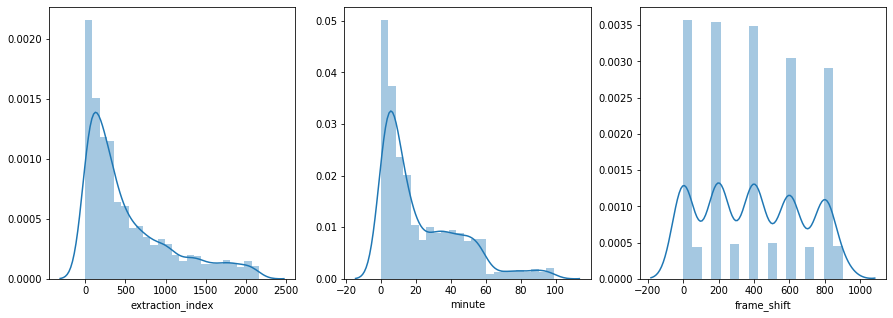

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.distplot(df_train.extraction_index)
plt.subplot(132)
sns.distplot(df_train.minute)
plt.subplot(133)
sns.distplot(df_train.frame_shift)

In [10]:
len(df_train.match_hash.unique())
# therefore 25 matches were used here

25

In [11]:
len(df_train.frame_idx.unique())
## there for it's unique

2978

#### explanation

- extraction_index: index of the extracted frame in a sequence, just for sorting purposes, some indices can exist multiple times
- match_hash: hashed match name
- minute: minute of the match, from which the frame comes
- frame_shift: during extraction, random frame shift (by number of frames equal to  frame_shift) is applied to increase diversity
- frame_idx: global frame index from a video

# displot analysis
 * first thing I have noticed is that we have a lot of frames at the start of the match, and very few towards the end. This has to be balanced out when splitting into traina and validation sets
 * 

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

# Testing data analysis

In [12]:
df_test[['extraction_index', 
        'match_hash',
        'minute',
        'frame_shift',
        'frame_idx']] = df_test['img_name'].str.split('-',expand=True)
df_test[['frame_idx', 'format']] = df_train['img_name'].str.split('.', expand=True)
df_test[['extraction_index', 'minute','frame_shift']] = df_test[['extraction_index', 'minute','frame_shift']].astype(np.int)

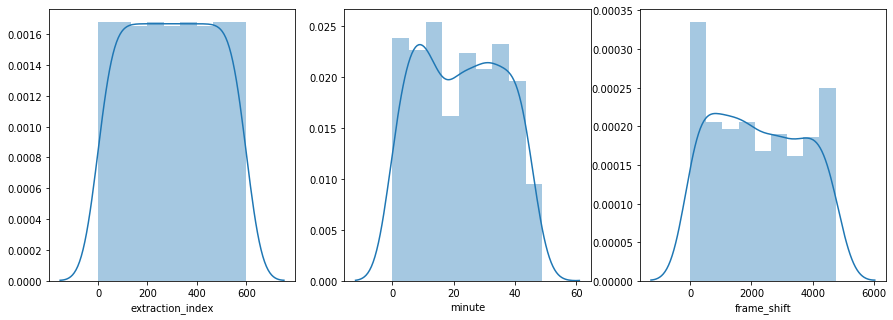

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.distplot(df_test.extraction_index)
plt.subplot(132)
sns.distplot(df_test.minute)
plt.subplot(133)
sns.distplot(df_test.frame_shift)

#ghings to look at tomorrow:
* https://www.ritchieng.com/the-incredible-pytorch/
* https://www.youtube.com/watch?v=rerCauAFeno
* https://github.com/facebookresearch/FixRes
* https://towardsdatascience.com/introduction-to-video-classification-6c6acbc57356
* https://github.com/ashrutkumar/Indoor-scene-recognition
* https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy-2


<img src="docs/img.jpeg" width=800 height=400 />

# Train test split $-$ brain storming
 * try to have a balance of minute count in both train and validation
 * don't have the same match in the train and validaiton set as to avoid overfitting
     * at the same time keeping a class balance between positive and negative classes in the two datasets

In [18]:
#Kombinacje bez powtórzeń

In [19]:
from itertools import chain, permutations, combinations

In [20]:
options = dict()

for match in df_train.match_hash.unique():
    
    n_pos = len(tmp[tmp.frame=='pos'])
    tmp = df_train[df_train.match_hash==match]
    total = tmp.shape[0]
    options.update({match : (n_pos, total)})

In [21]:
def get_class_balance(df):
    a, b = np.unique(df.frame, return_counts=True)
    df_size = sum(b)
    ratio = b[1]/df_size
    return df_size, ratio

In [22]:
def get_best_combination(df, options, test_size = 0.2, test_match_count=5):
    """
    Function returns the best combination of matches given a test_size. It also keeps the present class balance
    :param: df --dataframe to split
    :options: dict of all possible math tpe combinations along with a tuple with info about number of pos classes and total instances.
    :param: test_size -- test size
    :return train, val dataframes:
    """
    
    main_df_size, ratio = get_class_balance(df)

    #all_comb = [i for i in combinations(options, 5)]
    for comb in combinations(options, test_match_count):
    
        sum_pos, sum_all = 0, 0

        for match in comb:
            e = options[match]
            sum_pos+=e[0]
            sum_all+=e[1]

        frac = sum_pos/sum_all  #frac blance of pos class
        perc = sum_all/main_df_size #percent of entire dataset: 20/80 val/train split

        if abs(frac-ratio)<0.001 and abs(perc-test_size)<0.001:
            print("val: ", frac, perc)
            chosen_comb = comb
            #stops once a combination is found
            break
            
    val = df[df.match_hash.isin(list(chosen_comb))]
    train = df[~df.match_hash.isin(list(chosen_comb))]
    
    
    train_df_size, train_ratio = get_class_balance(train)
    print("train: ", train_ratio, train_df_size/main_df_size)
    
    return train, val

In [23]:
train, val = get_best_combination(df_train, options, test_size = 0.2, test_match_count=5)

val:  0.5510887772194305 0.20047011417058427
train:  0.5468290634187316 0.7995298858294158


In [24]:
len(train.match_hash.unique()), len(val.match_hash.unique())

(20, 5)

In [25]:
train.to_csv("data/train.csv")
val.to_csv("data/val.csv")

In [28]:
train.shape[0]/8

297.625